In [17]:
# import library
import shapefile
import geopandas
import laspy
from scipy import spatial
import whitebox
import CSF
import osgeo.ogr as ogr
import osgeo.osr as osr
import rasterio
import rasterio.plot as rplt
import open3d as o3d

from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import os

In [18]:
# Make a.shp file to extract the target area
def make_polygon(image_path, RTK_information_path):
    # get EPSG
    epsg = rasterio.open(image_path)
    EPSG = epsg.crs.to_epsg()
    
    # read RTK file
    sf = shapefile.Reader(RTK_information_path)
    shapes = sf.shapes()
    list_p = []
    num = 0
    for i in shapes:
        list_p.append(shapes[num].points[0])
        num += 1    
    rtk_dir,rtk_name=os.path.split(RTK_information_path)
    # Make polygon shaped.shp file
    driver = ogr.GetDriverByName("ESRI Shapefile")
    data_source = driver.CreateDataSource(rtk_dir+'\\'+'polygon.shp')
    poly_path = rtk_dir+'\\'+'polygon.shp'                                      
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(EPSG)
    
    layer = data_source.CreateLayer("polygon", srs, ogr.wkbMultiPolygon)

    feature = ogr.Feature(layer.GetLayerDefn())

    wkt = 'polygon((%f %f,%f %f,%f %f,%f %f,%f %f))' % (
        list_p[0][0],list_p[0][1],list_p[1][0],list_p[1][1],list_p[2][0],list_p[2][1],list_p[3][0],
        list_p[3][1],list_p[0][0],list_p[0][1])
    print(wkt)
    
    polygon = ogr.CreateGeometryFromWkt(wkt)

    feature.SetGeometry(polygon)

    layer.CreateFeature(feature)

    feature = None
    data_source = None
    
    sf_m = geopandas.read_file(RTK_information_path)
    sf_po = geopandas.read_file(poly_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    ax = axes.ravel()
    ax[0]=sf_m.plot(color='red',
            markersize=50,ax=ax[0])
    
    ax[0].set_title('ROI Points')

    ax[1]=sf_po.boundary.plot(color="red", zorder=10,ax=ax[1])
    ax[1].set_title('ROI Polygon')
    
    plt.tight_layout()
    
    plt.show()
    
    return poly_path, list_p

In [19]:
# Point cloud denoising
def denoising(las_path):
    las_dir,las_name=os.path.split(las_path)
    # LAS file location
    lasfile = las_path
    # Open the las file
    inFile = laspy.file.File(lasfile, mode = "r")
    #Read the XYZ coordinates of the point cloud
    x,y,z = inFile.x,inFile.y,inFile.z
    
    # Encapsulation x, y, z
    lasdata = zip(x,y,z)
    tree = spatial.cKDTree(list(lasdata))
    # Set the judgment to select several times standard deviation as the threshold and field points
    sigma=10  #std 
    K=50   #Neighborhood points
    #Creates an array of stored distances for each point field
    k_dist=np.zeros_like(x)
    #Find a point with a distance less than what
    for i in range(len(x)):
        dist,index =tree.query(np.array([x[i],y[i],z[i]]), K)
        k_dist[i] = np.sum(dist)
    #Determine the maximum threshold of noise
    max_distance = np.mean(k_dist) + sigma*np.std(k_dist)
    #Index of noise
    outer_index=np.where(k_dist>max_distance)
    print('outer points index array is:', outer_index)
    
    sor_filter = k_dist<=max_distance
    
    sor_path = las_dir+'\\'+'sor_'+las_name
    outFile = laspy.file.File(sor_path, 
                              mode='w', header=inFile.header)
    outFile.points = inFile.points[sor_filter]
    outFile.close()
    inFile.close()
    
    return sor_path, las_name

In [20]:
# Classified ground point
def ground_filtering(sor_path,las_name):
    las_dir,sor_name=os.path.split(sor_path)
    inFile_sor = laspy.file.File(sor_path, mode='r') 
    points_sor = inFile_sor.points
    xyz_sor = np.vstack((inFile_sor.x, inFile_sor.y, inFile_sor.z)).transpose()
    
    csf = CSF.CSF()
    csf.params.bSloopSmooth = False
    csf.params.cloth_resolution = 1
    csf.params.class_threshold =0.01
    csf.setPointCloud(xyz_sor)
    ground = CSF.VecInt()  
    non_ground = CSF.VecInt() 
    csf.do_filtering(ground, non_ground)
    
    ground_path = las_dir+'\\'+'ground_'+las_name
    outFile_ground = laspy.file.File(ground_path,mode='w', 
                             header=inFile_sor.header)
    outFile_ground.points = points_sor[ground] 
    outFile_ground.close()
    inFile_sor.close()
    
    return ground_path

In [21]:
# Generate CHM
def make_CHM(ground_path, sor_path, las_name):
    wbt = whitebox.WhiteboxTools()
    wbt.set_verbose_mode(False)
    las_dir,sor_name=os.path.split(sor_path)
    
    lasfile_ground = ground_path
    inFile_ground = laspy.file.File(lasfile_ground, mode = "r")
    x_ground,y_ground,z_ground = inFile_ground.x,inFile_ground.y,inFile_ground.z
    inFile_ground.close()

    wbt.lidar_elevation_slice(
        i=sor_path, 
        output=las_dir+'\\'+'sor_above_'+las_name, 
        minz=z_ground.min(), 
        maxz=None, 
        cls=False
    )

    wbt.lidar_tin_gridding(
        i= las_dir+'\\'+'sor_above_'+las_name, 
        output= las_dir+'\\'+'sor_above_'+las_name[:-4]+'.tif', 
        parameter="elevation", 
        returns="all", 
        resolution=0.01, 
        exclude_cls=None, 
        minz=None, 
        maxz=None, 
        max_triangle_edge_length=None 
    )

    wbt.lidar_tin_gridding(
        i= ground_path, 
        output= las_dir+'\\'+'ground_'+las_name[:-4]+'.tif', 
        parameter="elevation", 
        returns="all", 
        resolution=0.01, 
        exclude_cls=None, 
        minz=None, 
        maxz=None, 
        max_triangle_edge_length=None
    )

    
    wbt.clip_raster_to_polygon(
        i= las_dir+'\\'+'sor_above_'+las_name[:-4]+'.tif', 
        polygons= poly_path, 
        output= las_dir+'\\'+'sor_above_roi_'+las_name[:-4]+'.tif'
    )
 
    wbt.clip_raster_to_polygon(
        i= las_dir+'\\'+'ground_'+las_name[:-4]+'.tif', 
        polygons=poly_path, 
        output= las_dir+'\\'+'ground_roi'+las_name[:-4]+'.tif'
    )
    
    dem = las_dir+'\\'+'ground_roi'+las_name[:-4]+'.tif'

    with rasterio.open(dtm) as src:
        dem_im = src.read(1, masked=True)
        ext = rasterio.plot.plotting_extent(src)

    dsm = las_dir+'\\'+'sor_above_roi_'+las_name[:-4]+'.tif'

    with rasterio.open(dsm) as src:
        dsm_im = src.read(1, masked=True)
        dsm_meta = src.profile

    chm = dsm_im - dem_im

    nodatavalue = chm.min()
    chm_fi = np.ma.filled(chm, fill_value=nodatavalue)

    chm_meta = dsm_meta.copy()
    chm_meta.update({'nodata': nodatavalue})

    chm_path = las_dir+'\\'+'chm'+las_name[:-4]+'.tif'
    with rasterio.open(las_dir+'\\'+'chm'+las_name[:-4]+'.tif', 'w', **chm_meta) as ff:
        ff.write(chm_fi,1)
        
    return chm_path

In [22]:
def CHM_Visualization(chm_path):
    img = io.imread(chm_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(img, cmap=plt.cm.gray)
    axes[0].set_title('img')
    axes[1].imshow(img, cmap=plt.cm.jet)
    axes[1].set_title('img(jet)')

polygon((320567.703186 3424400.523929,320559.301746 3424364.995019,320576.170738 3424360.782987,320584.320343 3424396.177671,320567.703186 3424400.523929))


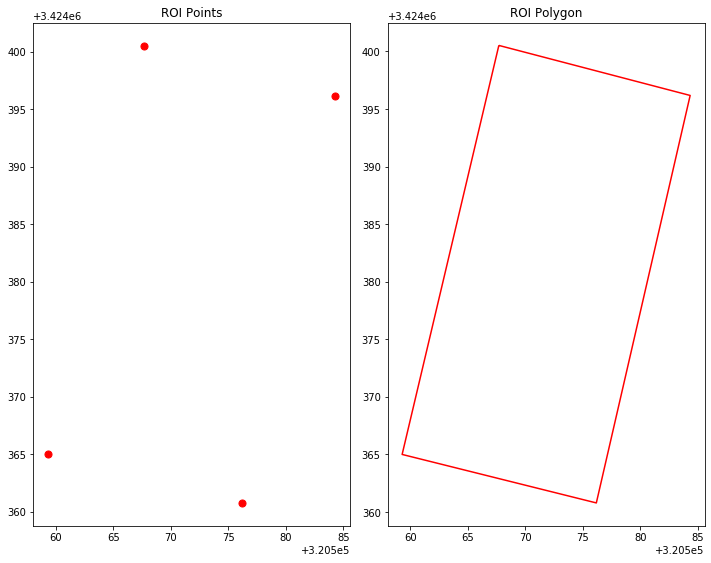

C:\Users\Think\Desktop\test\RTK_information\polygon.shp


In [23]:
# Step 1: Make a.shp file to extract the target area
image_path = r"C:\Users\Think\Desktop\test\2D_orthomosaic_image\20190807.tif"
RTK_information_path = r"C:\Users\Think\Desktop\test\RTK_information\s_mtps.shp"
poly_path, list_p=make_polygon(image_path, RTK_information_path)
print(poly_path)

In [24]:
# Step 2: Point cloud denoising
las_path = r"C:\Users\Think\Desktop\test\3D_point_cloud\20190807.las"
sor_path, las_name = denoising(las_path)
print(sor_path)

outer points index array is: (array([   19714,    30739,    31112, ..., 10299058, 10299514, 10303279],
      dtype=int64),)
C:\Users\Think\Desktop\test\3D_point_cloud\sor_20190807.las


In [25]:
# Step 3: Point cloud ground filtering
ground_path = ground_filtering(sor_path,las_name)
print(ground_path)

C:\Users\Think\Desktop\test\3D_point_cloud\ground_20190807.las


In [26]:
# Step 4: Generate canopy height model
chm_path = make_CHM(ground_path, sor_path, las_name)
print(chm_path)

C:\Users\Think\Desktop\test\3D_point_cloud\chm20190807.tif


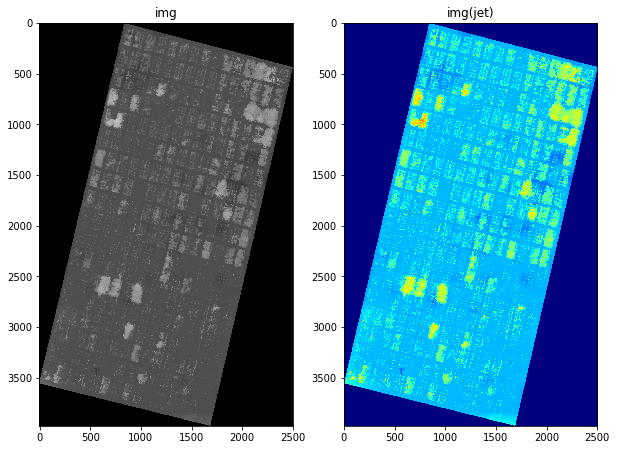

In [27]:
# Step 5: Visualize the canopy height model
CHM_Visualization(chm_path)